In [1]:
import pandas as pd
import glob
import os
base_path = '../../mocap_EMG_EEG_data/data_An_Yu/path1_02'
emg_files = glob.glob(os.path.join(base_path, 'EMG', '*.csv'))
emg_file_path = emg_files[0]
emg_file = pd.read_csv(emg_file_path, sep='\t')
emg_output_file_path = f'{base_path}/preprocessing/output/post_event_data.csv'

In [2]:
emg_file

,"Cygnus version: 0.28.0.7,File version: 2021.11"
0,Operative system: Windows
1,Record datetime: 2024-09-06 16:13:28.671
2,Device ID: STEEG_DG819201
3,Device verison:
4,Device bandwidth: DC to 131 Hz
...,...
63755,"63.745,528214,4109.15,12.25,10607.05,5795.58,7..."
63756,"63.746,528215,4115.53,12.4,10604.02,5794.72,77..."
63757,"63.747,528216,4118.11,13.0,10601.55,5794.74,77..."
63758,"63.748,528217,4115.66,14.05,10600.05,5795.7,77..."


In [3]:
file_info = emg_file.iloc[:10, :]
emg_file_cut = emg_file.iloc[10:, 0].apply(lambda x: x.split(','))
columns = file_info.iloc[9, 0].split(',')
our_data = pd.DataFrame(emg_file_cut.tolist(), columns=columns)
our_data

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF,Event Id,Event Date,Event Duration,Software Marker,Software Marker Name
0,0.000,464469,4136.06,-33.35,10453.24,5887.05,8639.89,-1112.85,-1013.16,5784.45,,,,,
1,0.001,464470,4119.38,-26.07,10450.49,5887.25,8639.98,-1112.16,-1012.84,5819.69,,,,,
2,0.002,464471,4106.44,-26.61,10448.79,5886.72,8640.0,-1111.56,-1012.57,5852.49,,,,,
3,0.003,464472,4099.7,-37.34,10448.71,5885.29,8639.89,-1111.07,-1012.38,5879.75,,,,,
4,0.004,464473,4099.54,-53.23,10450.09,5883.48,8639.59,-1110.66,-1012.23,5897.98,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63745,63.745,528214,4109.15,12.25,10607.05,5795.58,7707.81,-1671.89,-1023.16,5954.54,,,,,
63746,63.746,528215,4115.53,12.4,10604.02,5794.72,7709.71,-1673.01,-1023.92,5956.63,,,,,
63747,63.747,528216,4118.11,13.0,10601.55,5794.74,7711.45,-1674.23,-1024.69,5958.47,,,,,
63748,63.748,528217,4115.66,14.05,10600.05,5795.7,7713.03,-1675.58,-1025.52,5959.9,,,,,


>**CAUTION**
>the pd.df data above are in String type

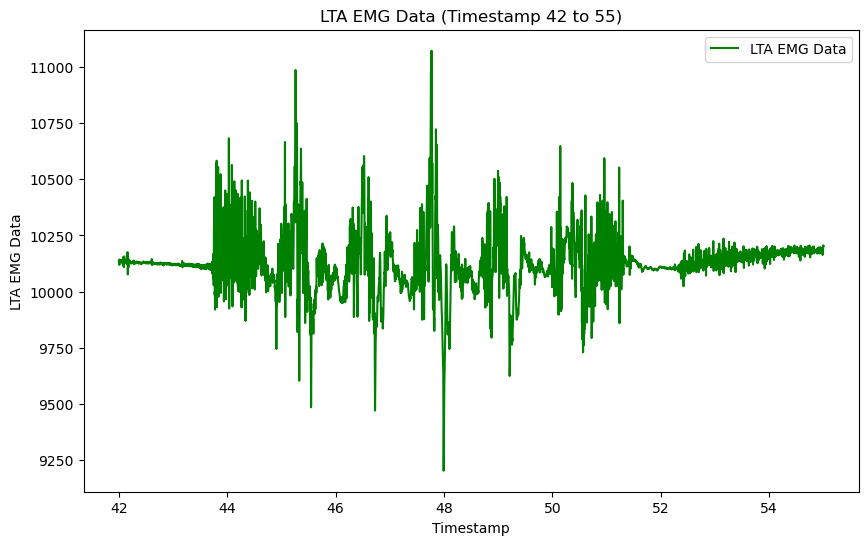

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

our_data['Timestamp'] = pd.to_numeric(our_data['Timestamp'], errors='coerce')
our_data['LTA'] = pd.to_numeric(our_data['LTA'], errors='coerce')

filtered_data = our_data[(our_data['Timestamp'] >= 42) & (our_data['Timestamp'] <= 55)]

plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Timestamp'], filtered_data['LTA'], label='LTA EMG Data', color='green')
plt.xlabel('Timestamp')
plt.ylabel('LTA EMG Data')
plt.title('LTA EMG Data (Timestamp 42 to 55)')
plt.legend()
plt.show()


In [5]:
event_id_indices = our_data[our_data['Event Id'].notna() & (our_data['Event Id'] != '')].index
event_id_indices

Index([28405, 38407, 40423, 42438, 43444, 43506, 43570, 43632, 43695, 43757,
       ...
       49412, 49413, 49476, 49538, 49600, 49665, 49727, 49728, 50734, 52747],
      dtype='int64', length=114)

## EMGprocessor

In [7]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import iirnotch, butter, filtfilt
from simulation.preprocessing.analysis.EMG_class import EMGProcessor


RANGE_OF_MUSCLE = 8
processed_our_data = np.zeros((our_data.shape[0], 2 + RANGE_OF_MUSCLE), dtype=float)

processor = EMGProcessor()
processed_our_data[:, :2] = our_data.iloc[:, :2]
for i in range(2, 2 + RANGE_OF_MUSCLE):
    column_data = pd.to_numeric(our_data.iloc[:, i], errors='coerce').fillna(0)
    processed_our_data[:, i] = processor.process(column_data)

In [8]:
columns = our_data.columns[:2 + RANGE_OF_MUSCLE]
col2index = {col: idx for idx, col in enumerate(columns)}
muscle_data = processed_our_data[:, col2index['LTA']]
print(col2index)

{'Timestamp': 0, 'Serial Number': 1, 'LGAST': 2, 'RGAST': 3, 'LTA': 4, 'RTA': 5, 'LBFL': 6, 'RBFL': 7, 'LRF': 8, 'RRF': 9}


In [9]:
processed_df = pd.DataFrame(processed_our_data, columns=our_data.columns[:2+RANGE_OF_MUSCLE])
processed_df.head()

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF
0,0.000,464469.0,3.895446,-8.540212,1.351002,0.511851,0.618147,0.112205,0.197614,0.511787
1,0.001,464470.0,4.005275,-8.099422,1.351261,0.534267,0.617328,0.121949,0.200063,0.653166
2,0.002,464471.0,4.115010,-7.660907,1.351582,0.556486,0.616478,0.131605,0.202491,0.793689
3,0.003,464472.0,4.224617,-7.224786,1.351967,0.578500,0.615599,0.141171,0.204898,0.933316
4,0.004,464473.0,4.334059,-6.791177,1.352415,0.600304,0.614690,0.150643,0.207282,1.072003


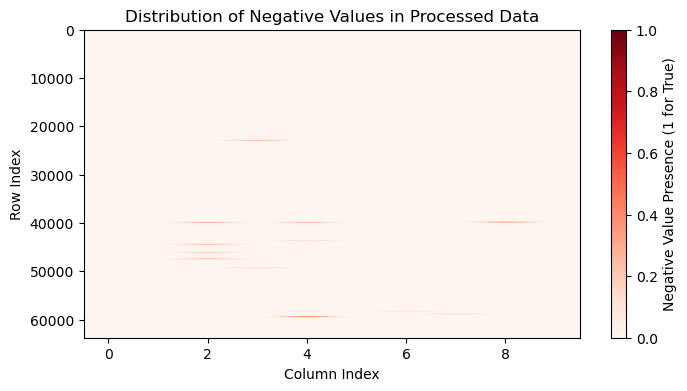

In [10]:
negative_mask = processed_our_data < 0
plt.figure(figsize=(8, 4))
plt.imshow(negative_mask, cmap='Reds', aspect='auto')

plt.title('Distribution of Negative Values in Processed Data')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

plt.colorbar(label='Negative Value Presence (1 for True)')
plt.show()

/tmp/ipykernel_459002/2517631603.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


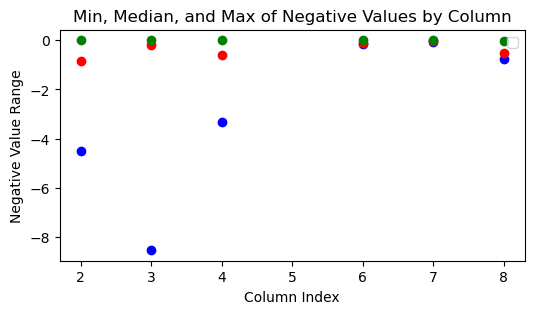

In [11]:
plt.figure(figsize=(6, 3))

for i in range(processed_our_data.shape[1]):
    negative_column_values = processed_our_data[:, i][negative_mask[:, i]]
    if len(negative_column_values) > 0:
        plt.plot(i, np.min(negative_column_values), 'bo', label='Min' if i == 0 else "")
        plt.plot(i, np.median(negative_column_values), 'ro', label='Median' if i == 0 else "")
        plt.plot(i, np.max(negative_column_values), 'go', label='Max' if i == 0 else "")

plt.legend(loc='upper right')
plt.title('Min, Median, and Max of Negative Values by Column')
plt.xlabel('Column Index')
plt.ylabel('Negative Value Range')

plt.show()

In [12]:
processed_our_data[processed_our_data<0] = 0
normed_our_data = np.copy(processed_our_data)
for i in range(2, 2 + RANGE_OF_MUSCLE):
    column_data = processed_our_data[:, i]
    normed_our_data[:, i] = processor.normalize_data(column_data)

processed_df = pd.DataFrame(normed_our_data, columns=our_data.columns[:2+RANGE_OF_MUSCLE])
processed_df.head()

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF
0,0.000,464469.0,0.016417,0.0,0.012099,0.002520,0.017250,0.001912,0.005578,0.006481
1,0.001,464470.0,0.016880,0.0,0.012101,0.002802,0.017227,0.002078,0.005647,0.010137
2,0.002,464471.0,0.017342,0.0,0.012104,0.003082,0.017203,0.002243,0.005716,0.013772
3,0.003,464472.0,0.017804,0.0,0.012107,0.003359,0.017179,0.002406,0.005784,0.017383
4,0.004,464473.0,0.018265,0.0,0.012111,0.003633,0.017153,0.002567,0.005851,0.020969


## Plot normalized data

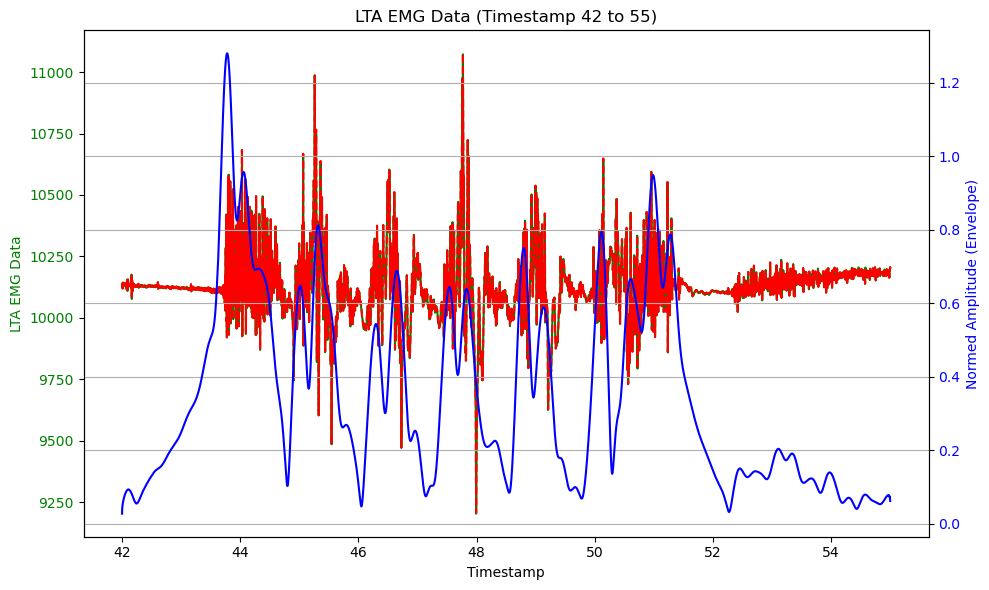

In [16]:
from scipy.signal import hilbert

MUSCLE_NAME = 'LTA'
# unit:s
start_flag = 42
end_flag = 55

our_data['Timestamp'] = pd.to_numeric(our_data['Timestamp'], errors='coerce')
our_data[MUSCLE_NAME] = pd.to_numeric(our_data[MUSCLE_NAME], errors='coerce')

filtered_data = our_data[(our_data['Timestamp'] >= start_flag) & (our_data['Timestamp'] <= end_flag)]
envelope_lta = np.abs(hilbert(filtered_data[MUSCLE_NAME]))

time_data = normed_our_data[:, col2index['Timestamp']]
muscle_data = normed_our_data[:, col2index[MUSCLE_NAME]]
filtered_normed_data = normed_our_data[(time_data >= start_flag) & (time_data <= end_flag)]
envelope_normed = np.abs(hilbert(filtered_normed_data[:, col2index[MUSCLE_NAME]]))

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(filtered_data['Timestamp'], filtered_data[MUSCLE_NAME], label=f'{MUSCLE_NAME} EMG Data', color='green')
ax1.plot(filtered_data['Timestamp'], envelope_lta, label=f'{MUSCLE_NAME} Envelope', color='red', linestyle='dashed')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(f'{MUSCLE_NAME} EMG Data', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(filtered_normed_data[:, col2index['Timestamp']], envelope_normed, label='Normed Data Envelope', color='blue')
ax2.set_ylabel('Normed Amplitude (Envelope)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f'{MUSCLE_NAME} EMG Data (Timestamp {start_flag} to {end_flag})')

fig.tight_layout()
plt.grid(True)
plt.show()


In [25]:
def calculate_snr(emg_data, standing_period, walking_period):
    """
    Parameters:
    emg_data: EMG data array (1D array).
    tuple (start_index, end_index).
    - standing_period as noise
    - walking_period as signal

    Returns:
    SNR value (expressed in dB).
    """
    standing_data = emg_data[standing_period[0]:standing_period[1]]
    walking_data = emg_data[walking_period[0]:walking_period[1]]
    noise_power = np.mean(standing_data ** 2)
    signal_power = np.mean(walking_data ** 2)
    
    if noise_power == 0:
        return float('inf')
    else:
        snr = 10 * np.log10(signal_power / noise_power)
        return snr
    
# 自動選擇最安靜的區間作為站立期
def find_quiet_period(emg_data, window_size=100):
    """
    自動找到最安靜的區間（即功率最小的一段）。
    
    Parameters:
    emg_data: EMG data array (1D array).
    window_size: The size of the window to calculate average power.
    
    Returns:
    Tuple of (start_index, end_index) representing the quiet period.
    """
    num_windows = len(emg_data) - window_size + 1
    min_power = float('inf')
    min_index = 0
    
    for i in range(num_windows):
        window_data = emg_data[i:i+window_size]
        window_power = np.mean(window_data ** 2)
        
        if window_power < min_power:
            min_power = window_power
            min_index = i
    
    return (min_index, min_index + window_size)

# 假設你想對 processed_our_data 的每一列進行 SNR 測量
RANGE_OF_MUSCLE = 8  # 假設有8列EMG信號數據
window_size = 1000  # 設置窗口大小來找安靜的區間

# 遍歷每個 EMG 信號列，計算SNR
for i in range(2, 2 + RANGE_OF_MUSCLE):
    emg_data = processed_our_data[:, i]
    
    # 找到最安靜的區間作為噪聲
    standing_period = find_quiet_period(emg_data, window_size)
    
    # 假設行走期是信號最強的區間，你可以根據具體需求設置行走期
    # 我們這裡假設行走期是最後一段信號
    walking_period = (len(emg_data) - window_size, len(emg_data))
    
    # 計算SNR
    snr = calculate_snr(emg_data, standing_period, walking_period)
    
    # 打印結果
    print(f'SNR for muscle {i-1}: {snr:.2f} dB')

SNR for muscle 1: 26.67 dB
SNR for muscle 2: 7.36 dB
SNR for muscle 3: 33.18 dB
SNR for muscle 4: 30.36 dB
SNR for muscle 5: 27.65 dB
SNR for muscle 6: 40.56 dB
SNR for muscle 7: 12.76 dB
SNR for muscle 8: 1.12 dB


### Archive

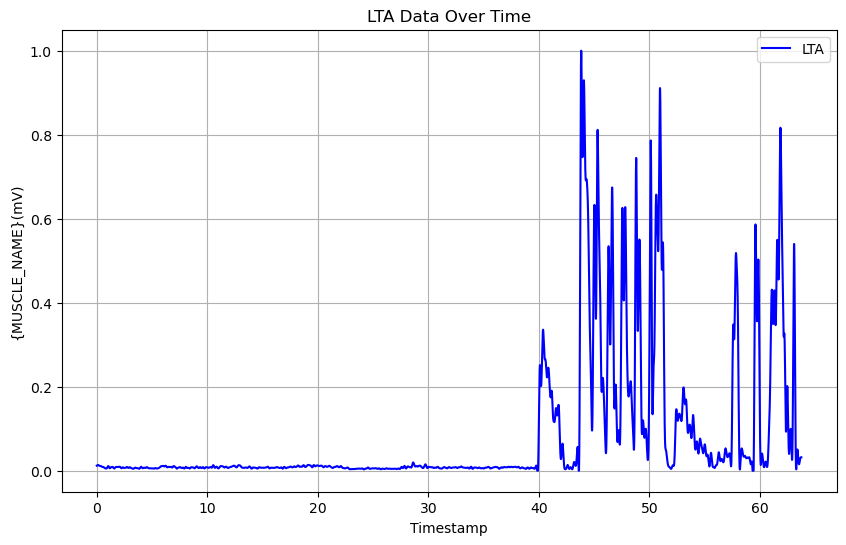

In [21]:
import matplotlib.pyplot as plt
time_data = normed_our_data[:, 0]

MUSCLE_NAME = 'LTA'
muscle_data = normed_our_data[:, col2index[MUSCLE_NAME]]

plt.figure(figsize=(10, 6))
plt.plot(time_data, muscle_data, label=MUSCLE_NAME, color='b')
plt.title(f'{MUSCLE_NAME} Data Over Time')
plt.xlabel(our_data.columns[0])
plt.ylabel(f"{{MUSCLE_NAME}}(mV)")
plt.legend()
plt.grid(True)
plt.show()


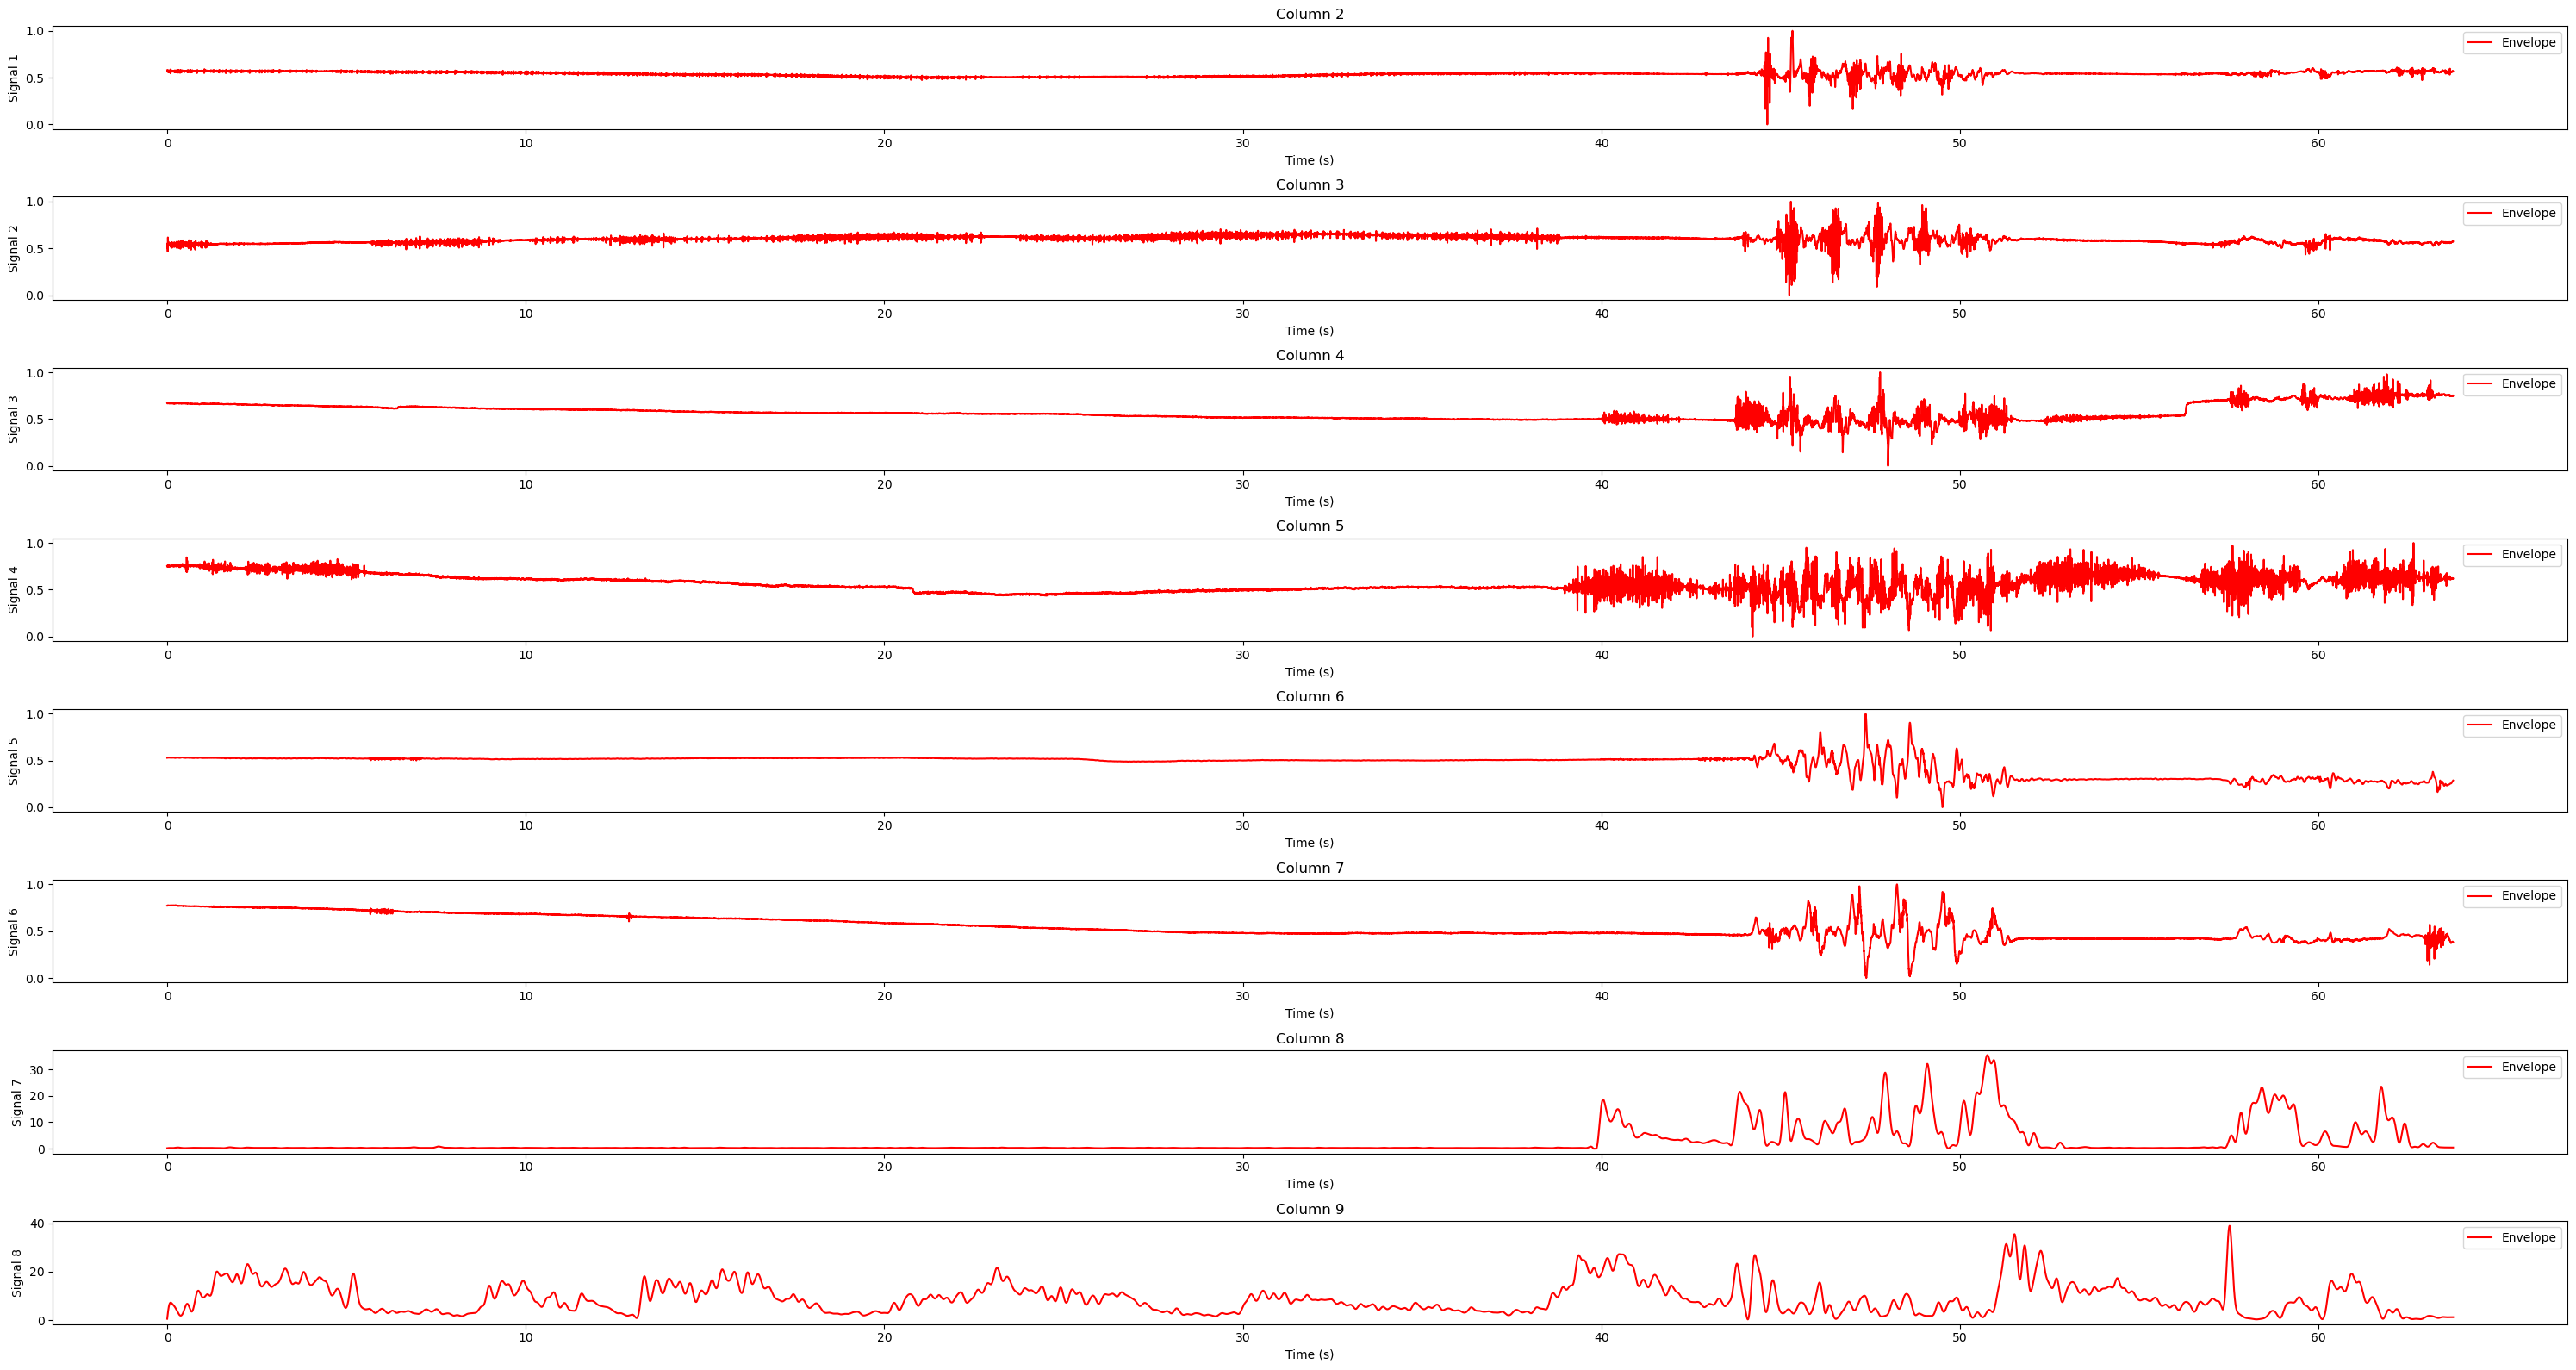

In [23]:
our_data_np =
time_our_data = np.arange(processed_our_data.shape[0]) / sampling_rate
plt.rcParams["figure.figsize"] = (30, 16)
fig, axes = plt.subplots(RANGE_OF_MUSCLE, 1)

for i in range(RANGE_OF_MUSCLE):
    axes[i].plot(time_our_data, processed_our_data[:, i + 2], label='Envelope', color='red')
    axes[i].set_title(f'Column {i + 2}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel(f'Signal {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()


# Other LAB's data
https://figshare.com/articles/dataset/EEG_Data/5616109/5

In [14]:
otherLAB_emg_data = loadmat('../../mocap_EMG_EEG_data/AB_UH_07T09emg.mat')['emg'][0,0]
left_emg = otherLAB_emg_data[0]
right_emg = otherLAB_emg_data[1]
sampling_rate = 1000

t = np.arange(left_emg.shape[1]) / sampling_rate

data = np.zeros((12,152666) ,dtype=float)

for i in range(6):
    data[i] = processor.process(left_emg[i, ...])
for i in range(6):
    data[i+6] = processor.process(right_emg[i, ...])
    
data[data < 0] = 0

for i in range(12):
    data[i] = processor.normalize_data(data[i])

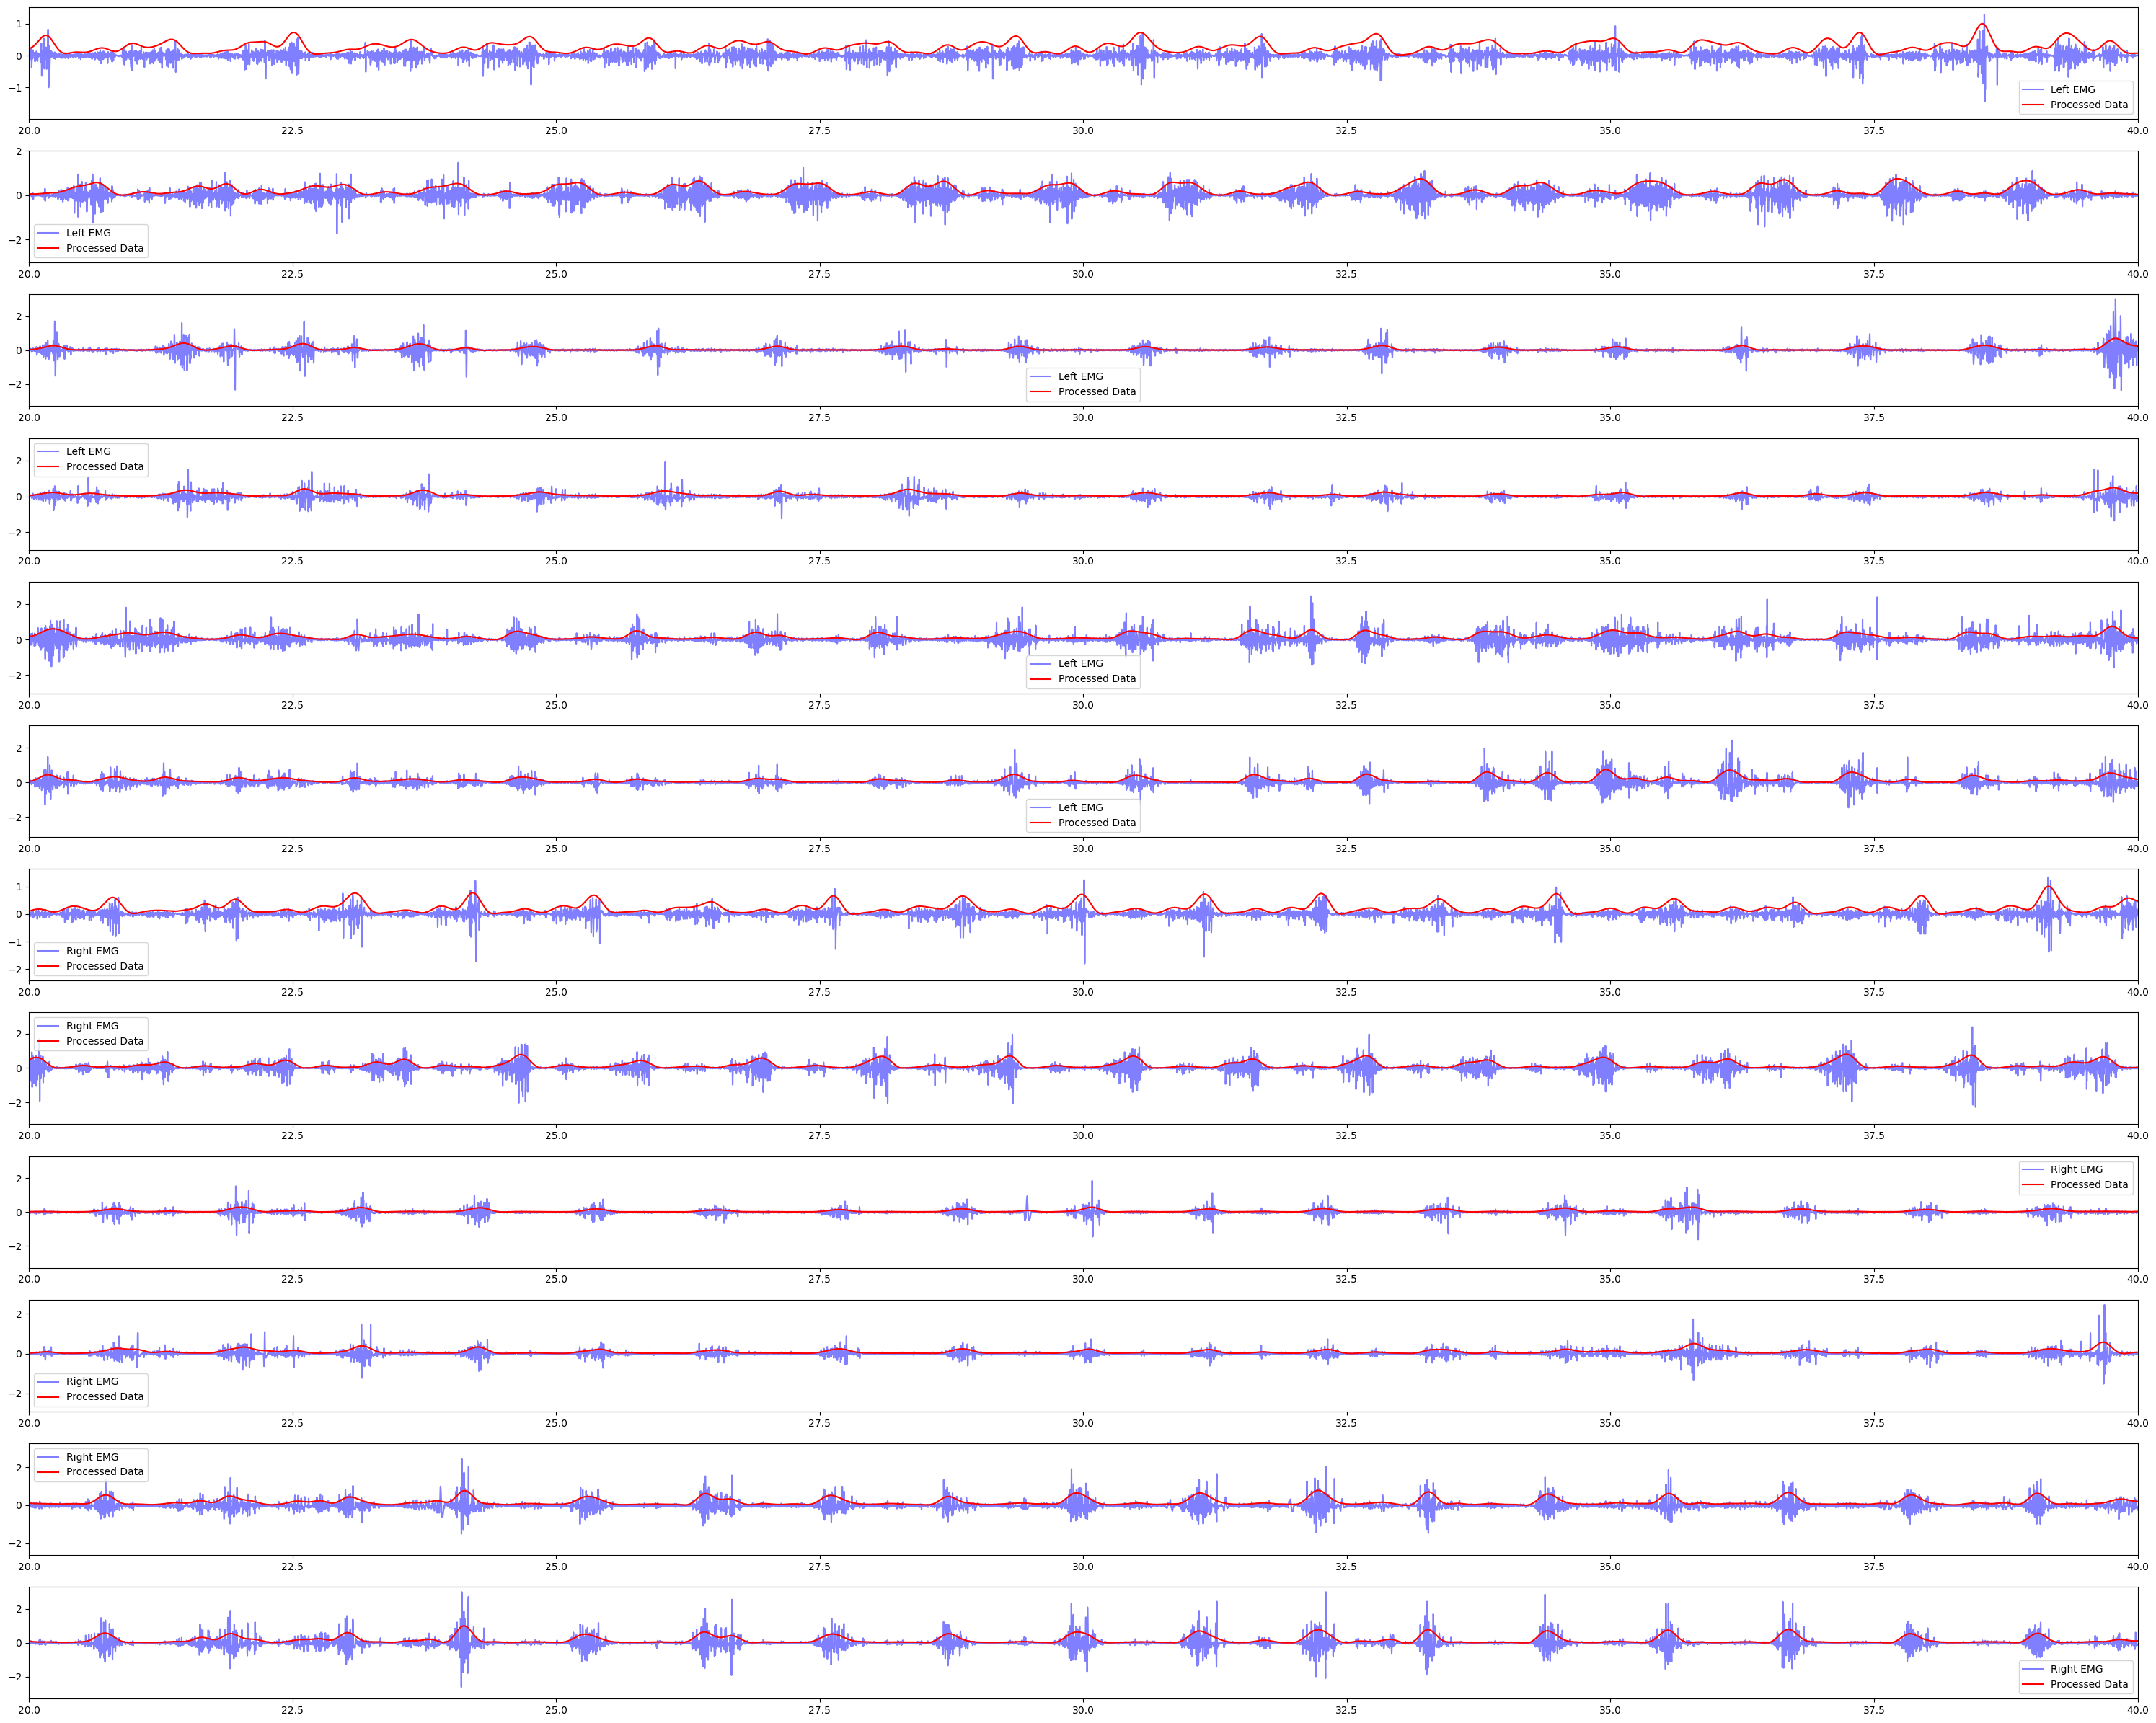

In [15]:
plt.rcParams["figure.figsize"] = (30, 24)
fig, axes = plt.subplots(12, 1)
xmin, xmax = 20, 40

for i in range(12):
    if i < 6:
        axes[i].plot(t, left_emg[i], label='Left EMG', color='blue', alpha=0.5)
    else:
        axes[i].plot(t, right_emg[i-6], label='Right EMG', color='blue', alpha=0.5)
    
    axes[i].plot(t, data[i], label='Processed Data', color='red')
    axes[i].set_xlim([xmin, xmax])
    axes[i].legend()

plt.tight_layout()
plt.show()


In [5]:
standing_period = (5,15)
walking_period = (20,40)
for i in range(12):
    snr = calculate_snr(data1[i], standing_period, walking_period)
    print(snr)

4.30738502337433
2.334654835696233
6.7666095385748015
3.9769358836922946
3.033686396652619
24.074908629657283
3.4450475391864632
3.4443687170384054
5.311556059226179
8.692673683334423
3.5336178730002348
2.420856560069366


In [8]:
standing_period = (5,20)
walking_period = (45,50)
for i in range(8):
    snr = calculate_snr(data2[i], standing_period, walking_period)
    print(snr)

4.1344372472622775
inf
0.40046696464346637
6.406094262647231
-0.7785714961163985
5.862624849875883
1.8743434176019624
8.889994858853928
